In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
from scipy import stats
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import scipy
from scipy import linalg
from matplotlib import pyplot
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm

Import data

In [2]:
Usedcar_ML = pd.read_csv(f'C:/Users/Student/Desktop/usedcar/sorted_result_eda.csv')
Usedcar_ML = Usedcar_ML.drop(columns='Unnamed: 0')

Encode target labels with value between 0 and n_classes-1.

In [3]:
le = preprocessing.LabelEncoder()
Usedcar_ML['Model'] = le.fit_transform(Usedcar_ML['Model'])
Usedcar_ML['State'] = le.fit_transform(Usedcar_ML['State'])
Usedcar_ML['BodyStyle'] = le.fit_transform(Usedcar_ML['BodyStyle'])
Usedcar_ML['Transmission'] = le.fit_transform(Usedcar_ML['Transmission'])
Usedcar_ML['FuelType'] = le.fit_transform(Usedcar_ML['FuelType'])
Usedcar_ML['Engine'] = le.fit_transform(Usedcar_ML['Engine'])
Usedcar_ML['Drivetrain'] = le.fit_transform(Usedcar_ML['Drivetrain'])

Feature selection before converting categorical variables into dummy/indicator variables

In [4]:
Usedcar_ML = Usedcar_ML[['GasMileage_highway', 'GasMileage_city','Model', 'State','Transmission', 'FuelType', 
                          'Engine', 'Drivetrain', 'BodyStyle', 'Year', 'Mileage', 'OptionCount','Price']]
Usedcar_ML = pd.get_dummies(Usedcar_ML, columns=['Model', 'FuelType', 'State', 'Transmission', 'Engine',
                                                  'Drivetrain', 'BodyStyle'])

train_x, test_x, train_y, test_y = train_test_split(Usedcar_ML.drop('Price',axis=1), Usedcar_ML['Price'], test_size=0.3)

Transform the dataset into xgboost data structure.
DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 

In [9]:
Data_train = xgb.DMatrix(train_x, label=train_y)
Data_test = xgb.DMatrix(test_x, label=test_y)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


## XGBoost Random Forest

In [10]:
#parameters setting
param = {}
param['booster'] = 'gbtree' 
param['tree_method'] = 'hist'
param['learning_rate'] = 0.5
param['silent']=1
param['max_depth']=10
eval_list  = [(Data_train,'train'),(Data_test,'test')]
num_round = 150
eval_history={}

# model training

model = xgb.train(param, Data_train, num_round,eval_list,
                  evals_result=eval_history, verbose_eval=False)



In [11]:
eval_history

{'train': {'rmse': [11972.521484,
   6845.154297,
   4579.526855,
   3725.829102,
   3364.055664,
   3215.625732,
   3143.645752,
   3100.881104,
   3077.615234,
   3050.936279,
   3034.036133,
   3015.514893,
   2982.586914,
   2969.36499,
   2957.705811,
   2943.605225,
   2931.4021,
   2916.222412,
   2907.97876,
   2889.527588,
   2879.249756,
   2860.624268,
   2852.068115,
   2842.289551,
   2834.864014,
   2828.005859,
   2817.821777,
   2813.340332,
   2797.346191,
   2791.822998,
   2787.484375,
   2777.997559,
   2773.236084,
   2768.665283,
   2762.825684,
   2757.552734,
   2753.776123,
   2748.244141,
   2733.297363,
   2729.385742,
   2727.224365,
   2718.471924,
   2705.397949,
   2699.499268,
   2693.930176,
   2689.808838,
   2687.591309,
   2684.657715,
   2681.819336,
   2678.131104,
   2673.23584,
   2670.700439,
   2667.391602,
   2663.38208,
   2658.700928,
   2654.557861,
   2653.211426,
   2650.785889,
   2647.490234,
   2637.422363,
   2620.604492,
   2616.9748

In [12]:
rmse_train=eval_history['train']['rmse']
rmse_test=eval_history['test']['rmse']

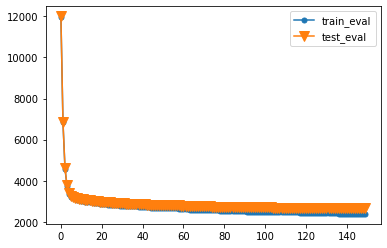

In [13]:
plt.plot(rmse_train,ms=10,marker='.',label='train_eval')
plt.plot(rmse_test,ms=10,marker='v',label='test_eval')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import r2_score
testY_pred = model.predict(Data_test)
r2_score(test_y, testY_pred)

0.9376356545117562

In [19]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
regressor.fit(train_x, train_y)
y_pred = regressor.predict(test_x)

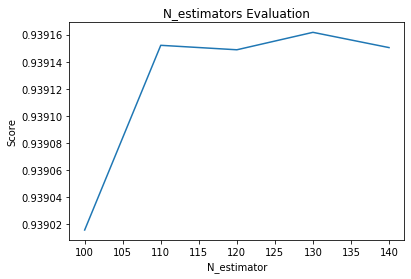

In [5]:
model = RandomForestRegressor(n_jobs=-1)
estimators = np.arange(100, 150, 10)
models = []
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(train_x, train_y)
    models.append(model)
    scores.append(model.score(test_x, test_y))
plt.title("N_estimators Evaluation")
plt.xlabel('N_estimator')
plt.ylabel("Score")
plt.plot(estimators, scores)

In [21]:
r2_score(test_y, y_pred)

0.9393762042975542

In [22]:
adj_r2 = 1-(1-r2_score(test_y, y_pred))*(train_x.shape[0]-1)/(train_x.shape[0]-train_x.shape[1])
adj_r2

0.9393395080036098

In [23]:
importances = regressor.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(train_x.shape[1]):
    print(f'{train_x.columns[indices[f]]}  :  {importances[indices[f]]}')

Year  :  0.2463630223339865
GasMileage_city  :  0.2407209418187182
Mileage  :  0.12215227113037198
Drivetrain_3  :  0.07677290721957698
GasMileage_highway  :  0.05914889480768155
OptionCount  :  0.02228721048520979
Model_211  :  0.01933262775788295
Engine_25  :  0.012582873019707896
Engine_19  :  0.011733198171337443
BodyStyle_8  :  0.011118745167604393
Model_31  :  0.008204778353728896
Engine_16  :  0.007830321809730418
Model_414  :  0.0072775982212891655
Drivetrain_0  :  0.0061368190485808286
Model_227  :  0.00606131006180615
BodyStyle_6  :  0.005989493638293553
BodyStyle_2  :  0.005134962633135988
Model_398  :  0.005020035370985652
Model_129  :  0.0038097416100217633
Engine_13  :  0.003759453424540861
Model_546  :  0.003504494490854504
BodyStyle_1  :  0.003258461965769273
Model_356  :  0.003105937110482703
Drivetrain_1  :  0.002984230941548066
Model_413  :  0.0028989033045130025
Model_217  :  0.002798275594929954
Engine_6  :  0.002650655181545408
Model_397  :  0.0023752447507011335


In [24]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 1741.9170299170685
Mean Squared Error: 6858216.321024755
Root Mean Squared Error: 2618.8196427063767
